In [1]:
# Imports for PyTorch model building, dataset handling, transforms, pretrained ResNet-18, visualization, and counting utilities

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from torchvision.datasets import ImageFolder
import os
from torchvision.models import resnet18, ResNet18_Weights
import matplotlib.pyplot as plt
import numpy as np
import random


In [2]:
# checking if CUDA-enabled GPU is available
if torch.cuda.is_available():
    gpu_name=torch.cuda.get_device_name(0)
    print(f"GPU is available: {gpu_name}")

GPU is available: NVIDIA GeForce RTX 3050 6GB Laptop GPU


In [3]:
# specifiying dataset directory
train_dir = "train"
test_dir  = "test"

In [4]:
# checking number of classes
train_dataset=ImageFolder(train_dir)
print("Classes:", train_dataset.classes)
print("Number of classes:", len(train_dataset.classes))
print("Number of training images:", len(train_dataset))

Classes: ['angry', 'disgusted', 'fearful', 'happy', 'neutral', 'sad', 'surprised']
Number of classes: 7
Number of training images: 28709


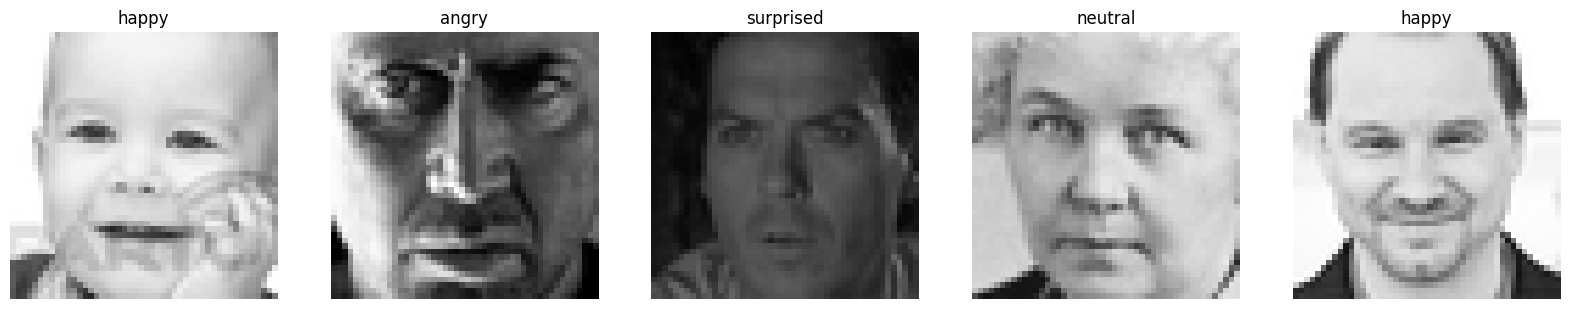

In [5]:
# random samples before transformation
def show_random_original_samples(dataset, num_samples=5):
    indices = random.sample(range(len(dataset)), num_samples)
    
    fig, axes = plt.subplots(1, num_samples, figsize=(4*num_samples, 4))
    
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        axes[i].imshow(img)
        axes[i].set_title(dataset.classes[label])
        axes[i].axis('off')
    
    plt.show()

# Show 5 random samples before transformation
show_random_original_samples(train_dataset, num_samples=5)


ResNet-18 expects:
- 224x224 images
- 3 channels (RGB)
- Normalized with ImageNet mean/std

In [6]:
# applying transformations
train_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

In [7]:
train_dataset = ImageFolder(root='train', transform=train_transforms)
test_dataset = ImageFolder(root='test', transform=test_transforms)

In [8]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=8)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=8)

Original Image:
Type: <class 'PIL.Image.Image'>
Dimensions (W x H): (48, 48)
Mode (channels): RGB

Transformed Image
Type: <class 'torch.Tensor'>
Shape (C x H x W): torch.Size([3, 224, 224])
Number of channels: 3
Height x Width: 224 x 224
Min pixel value (normalized): -1.9124069213867188
Max pixel value (normalized): 1.8382571935653687


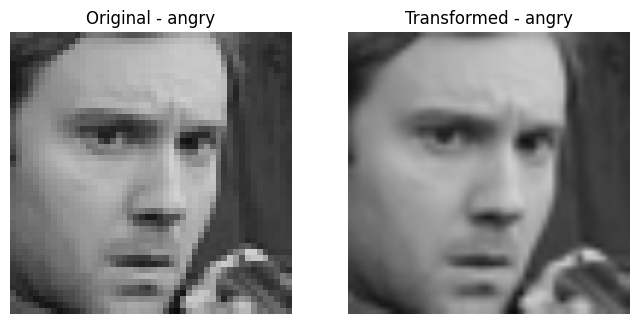

In [9]:
# Load original dataset without transforms
original_dataset = ImageFolder(root='train', transform=None)

# Pick the same sample
img_orig, label = original_dataset[0]  # original PIL image
img_tensor, _ = train_dataset[0]       # transformed tensor

print("Original Image:")
print("Type:", type(img_orig))
print("Dimensions (W x H):", img_orig.size)
print("Mode (channels):", img_orig.mode)

print("\nTransformed Image")
print("Type:", type(img_tensor))
print("Shape (C x H x W):", img_tensor.shape)
print("Number of channels:", img_tensor.shape[0])
print("Height x Width:", img_tensor.shape[1], "x", img_tensor.shape[2])
print("Min pixel value (normalized):", img_tensor.min().item())
print("Max pixel value (normalized):", img_tensor.max().item())

# Denormalize transformed image for plotting
mean = torch.tensor([0.485,0.456,0.406]).view(3,1,1)
std = torch.tensor([0.229,0.224,0.225]).view(3,1,1)
img_denorm = img_tensor * std + mean
img_denorm = img_denorm.clamp(0,1)
img_np = img_denorm.permute(1,2,0).numpy() 

fig, axes = plt.subplots(1,2, figsize=(8,4))

# Original
axes[0].imshow(img_orig)
axes[0].set_title(f"Original - {original_dataset.classes[label]}")
axes[0].axis('off')

# Transformed
axes[1].imshow(img_np)
axes[1].set_title(f"Transformed - {train_dataset.classes[label]}")
axes[1].axis('off')

plt.show()


In [10]:
# defining number of classes and model
num_classes = len(train_dataset.classes)  

# training resnet18 from scratch not using pretrained weights
model = models.resnet18(weights=None) 

# Replace the final fully connected layer to match number of classes
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


In [11]:
print("ResNet-18 architecture:")
print(model)

ResNet-18 architecture:
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu

#### ResNet-18 Architecture Overview

ResNet-18 is a convolutional neural network designed for image classification. Here’s a breakdown of its architecture:

**Input Requirements:**
- Image size: 224 × 224 pixels  
- Channels: 3 (RGB)

**Architecture Components:**

1. **Initial Convolution and Pooling**
   - conv1: Conv2d(3 → 64, kernel=7×7, stride=2, padding=3)  
   - bn1: BatchNorm2d(64)  
   - relu: ReLU activation  
   - maxpool: MaxPool2d(kernel=3, stride=2, padding=1)  

2. **Residual Layers**
   - Layer 1: 2 × BasicBlock(64 → 64)  
   - Layer 2: 2 × BasicBlock(64 → 128) with downsampling in the first block  
   - Layer 3: 2 × BasicBlock(128 → 256) with downsampling in the first block  
   - Layer 4: 2 × BasicBlock(256 → 512) with downsampling in the first block  

   *Each BasicBlock contains:*
   - conv1 → Conv2d with same input/output channels  
   - bn1 → Batch normalization  
   - relu → ReLU activation  
   - conv2 → Conv2d  
   - bn2 → Batch normalization  
   - Optional downsample if input and output dimensions differ  

3. **Global Pooling and Fully Connected Layer**
   - avgpool: AdaptiveAvgPool2d(output_size=(1,1))  
   - fc: Linear(512 → 7)  → outputs 7 classes (emotions)  

**Notes:**
- Skip connections (residual connections) are used to prevent vanishing gradients.  
- Downsampling occurs at the beginning of layers 2, 3, and 4 to reduce spatial dimensions while increasing channel depth.  
- The final `fc` layer is replaced to match the number of target classes (7 emotions in this case).  


### What changes?

- Instead of using pretrained weights from ImageNet, all weights are initialized randomly.
- The original fc layer outputs 1000 classes (for ImageNet).
- We replace it to output the number of classes in our dataset (7 emotions).
- All layers, including early convolutional layers, will learn features from our dataset instead of using pretrained features.

When training a model from scratch, we are starting with randomly initialized weights, so the network has no idea how to classify images yet. To train it, we need two key components:

- Loss function (CrossEntropyLoss) – Measures how far the model’s predictions are from the true labels for multi-class classification.
- Optimizer (Adam) – Updates the model’s weights to minimize the loss. model.parameters() tells it which weights to train, and lr=1e-3 sets the learning rate.

Together, these guide the model from random initialization to learning meaningful features from the data.

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [13]:
num_epochs = 10

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    train_loss = running_loss / total
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # Validation
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()

    test_loss /= test_total
    test_acc = 100 * test_correct / test_total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% "
          f"Test Loss: {test_loss:.4f} Test Acc: {test_acc:.2f}%")


Epoch [1/10] Train Loss: 1.7002 Train Acc: 31.25% Test Loss: 1.7391 Test Acc: 35.20%
Epoch [2/10] Train Loss: 1.3381 Train Acc: 48.69% Test Loss: 1.4622 Test Acc: 46.39%
Epoch [3/10] Train Loss: 1.1921 Train Acc: 54.43% Test Loss: 1.1685 Test Acc: 55.71%
Epoch [4/10] Train Loss: 1.1076 Train Acc: 58.21% Test Loss: 1.1373 Test Acc: 56.61%
Epoch [5/10] Train Loss: 1.0466 Train Acc: 60.40% Test Loss: 1.1123 Test Acc: 58.36%
Epoch [6/10] Train Loss: 0.9876 Train Acc: 62.97% Test Loss: 1.0998 Test Acc: 59.21%
Epoch [7/10] Train Loss: 0.9366 Train Acc: 64.74% Test Loss: 1.1487 Test Acc: 56.56%
Epoch [8/10] Train Loss: 0.8881 Train Acc: 66.71% Test Loss: 1.0408 Test Acc: 61.57%
Epoch [9/10] Train Loss: 0.8298 Train Acc: 68.70% Test Loss: 1.0526 Test Acc: 62.04%
Epoch [10/10] Train Loss: 0.7682 Train Acc: 71.34% Test Loss: 1.0325 Test Acc: 63.34%


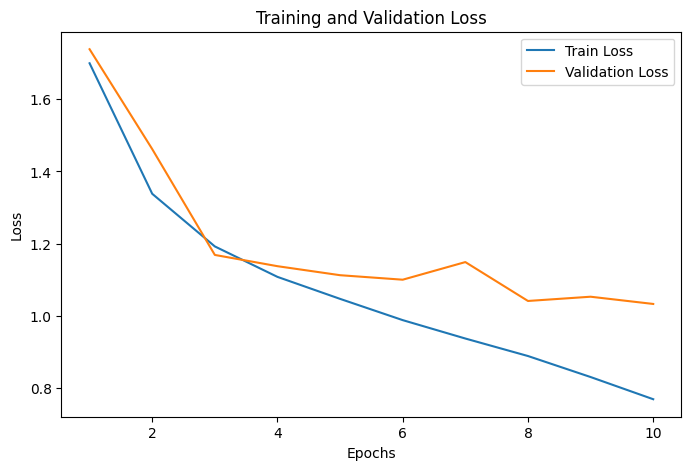

In [ ]:
# Plotting loss
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

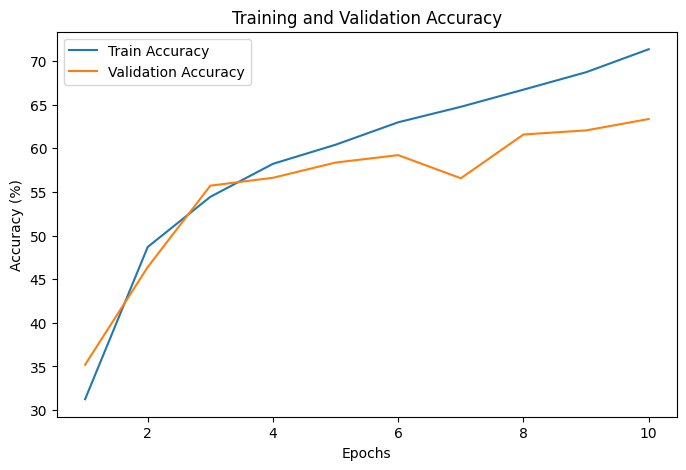

In [15]:
# Plot accuracy
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [16]:
torch.save(model.state_dict(), "resnet18_emotion_scratch.pth")

### Using pre-trained model instead of training ResNet-18 from scratch

- We apply transfer learning using a pretrained ResNet-18 model for emotion classification. 
- All layers except the final fully connected layer are frozen, so the pretrained convolutional layers act as a feature extractor. 
- The original final layer is replaced with a new layer matching our 7 emotion classes and trained on our dataset. 
- This allows the model to leverage learned features from ImageNet while adapting to the emotion recognition task, resulting in faster training and better performance with fewer images.

In [17]:
# using pre trained weights from imagenet
ft_model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

In [18]:
num_classes = len(train_dataset.classes)

# Freeze all layers except the final fully connected layer
for param in ft_model.parameters():
    param.requires_grad = False

# new output layer
ft_model.fc = nn.Linear(ft_model.fc.in_features, num_classes)  

ft_model = ft_model.to(device)


In [19]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(ft_model.fc.parameters(), lr=1e-4) # We are only optimizing the parameters of the final fully connected layer

In [21]:
# transfer learning with frozen pretrained layers
num_epochs = 10 

train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(num_epochs):
    # Training
    ft_model.train()
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = ft_model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
        
    train_loss = running_loss / total
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Validation
    ft_model.eval()
    test_loss, test_correct, test_total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = ft_model(images)
            loss = criterion(outputs, labels)
            
            test_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            test_total += labels.size(0)
            test_correct += predicted.eq(labels).sum().item()
            
    test_loss /= test_total
    test_acc = 100 * test_correct / test_total
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} Train Acc: {train_acc:.2f}% "
          f"Test Loss: {test_loss:.4f} Test Acc: {test_acc:.2f}%")


Epoch [1/10] Train Loss: 1.7841 Train Acc: 25.66% Test Loss: 1.7123 Test Acc: 30.42%
Epoch [2/10] Train Loss: 1.6564 Train Acc: 34.85% Test Loss: 1.6306 Test Acc: 36.18%
Epoch [3/10] Train Loss: 1.5962 Train Acc: 38.62% Test Loss: 1.5889 Test Acc: 38.24%
Epoch [4/10] Train Loss: 1.5611 Train Acc: 40.51% Test Loss: 1.5606 Test Acc: 39.65%
Epoch [5/10] Train Loss: 1.5360 Train Acc: 41.38% Test Loss: 1.5346 Test Acc: 41.03%
Epoch [6/10] Train Loss: 1.5179 Train Acc: 42.22% Test Loss: 1.5212 Test Acc: 41.59%
Epoch [7/10] Train Loss: 1.5043 Train Acc: 42.96% Test Loss: 1.5081 Test Acc: 42.28%
Epoch [8/10] Train Loss: 1.4938 Train Acc: 43.08% Test Loss: 1.5021 Test Acc: 42.75%
Epoch [9/10] Train Loss: 1.4842 Train Acc: 43.57% Test Loss: 1.4958 Test Acc: 42.76%
Epoch [10/10] Train Loss: 1.4761 Train Acc: 44.06% Test Loss: 1.4866 Test Acc: 43.14%


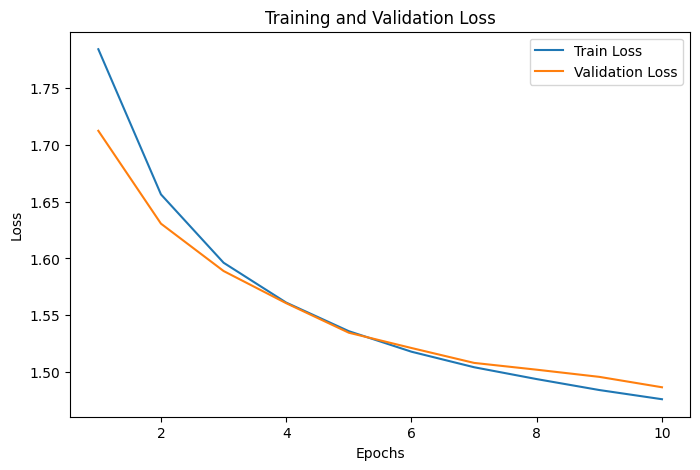

In [22]:
# Plotting
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

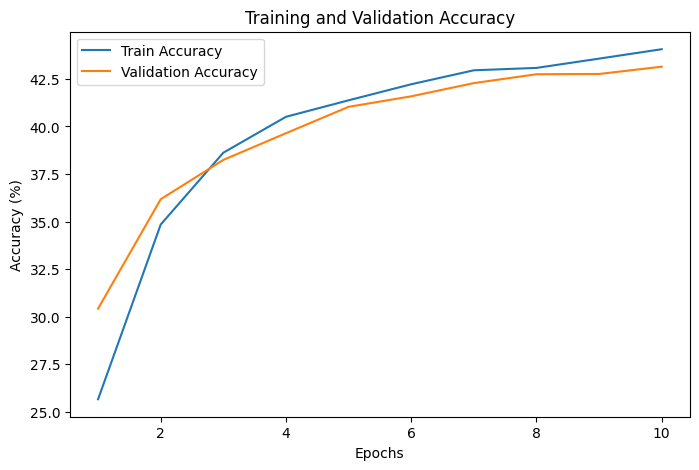

In [23]:
# Plot accuracy
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()